# Introduction

For Assignment 2, I have built a deep learning model to perform end-to-end machine translation from English to French. This pipeline will accpet text in English as inputs and produce its French translation accordingly. To produce the best possible model, I have tested a few before finalizing the one to be used ultimately for this task.

# 1. Getting Started

In [15]:
# pre-start setup
%load_ext autoreload
%aimport helper
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# import all necessary libraries to start

import warnings
warnings.filterwarnings('ignore')

import os
import collections
import numpy as np
import matplotlib. pyplot as plt
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import LSTM, GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.utils import plot_model

# 2.  Load Data & Show Examples

In [8]:
# load data with given path
def load_data(path):

    input_file = os.path.join(path)
    with open(input_file, "r") as f:
        data = f.read()

    return data.split('\n')

# load the English data
english_sentences = load_data('data/en_data')

# load the French data
french_sentences = load_data('data/fr_data')

# print the first two lines from each file
for sample_i in range(2):
    print('en_data Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('fr_data Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

en_data Line 1:  the united states is usually chilly during july , and it is usually freezing in november .
fr_data Line 1:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .
en_data Line 2:  california is usually quiet during march , and it is usually hot in june .
fr_data Line 2:  california est généralement calme en mars , et il est généralement chaud en juin .


From example sentences, it is clear that the data has been preprocessed a bit. For example, all texts have been converted to lowercase. However, further data preprocessing is needed before being used for training purposes.


# 3. Data Pre-processing


In [9]:
# show the stats of the datasets
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('The English dataset has {} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('The top 10 most common words are:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('The French dataset has {} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('The top 10 most common words are:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

The English dataset has 1823235 English words.
227 unique English words.
The top 10 most common words are:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

The French dataset has 1961279 French words.
355 unique French words.
The top 10 most common words are:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


### Tokenization

In [10]:
# tokenize x, from input of a list of sentences/strings to be tokenized
def tokenize(x):
    x_tk = Tokenizer()
    # Tokenize x
    x_tk.fit_on_texts(x)
    # return a tuple of tokenized x data and tokenizer used to tokenize 
    return x_tk.texts_to_sequences(x), x_tk

# examples to be tokenized
text_sentences = [
    'I do not want to go .',
    'It is a good day .',
    'Cooking is not only a good hobby, but also a good habit .']

# tokenize example output and print the results
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'a': 1, 'good': 2, 'not': 3, 'is': 4, 'i': 5, 'do': 6, 'want': 7, 'to': 8, 'go': 9, 'it': 10, 'day': 11, 'cooking': 12, 'only': 13, 'hobby': 14, 'but': 15, 'also': 16, 'habit': 17}

Sequence 1 in x
  Input:  I do not want to go .
  Output: [5, 6, 3, 7, 8, 9]
Sequence 2 in x
  Input:  It is a good day .
  Output: [10, 4, 1, 2, 11]
Sequence 3 in x
  Input:  Cooking is not only a good hobby, but also a good habit .
  Output: [12, 4, 3, 13, 1, 2, 14, 15, 16, 1, 2, 17]


### Padding

In [11]:
# pad input x
def pad(x, length=None):
    # check the length to pad the sequence to.  If None, use length of longest sequence in x.
    if length is None:
        length = len(max(x, key=len))
    # return padded numpy array of sequences
    return pad_sequences(x, maxlen=length, padding='post')


# pad Tokenized output and print the resultss
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [5 6 3 7 8 9]
  Output: [5 6 3 7 8 9 0 0 0 0 0 0]
Sequence 2 in x
  Input:  [10  4  1  2 11]
  Output: [10  4  1  2 11  0  0  0  0  0  0  0]
Sequence 3 in x
  Input:  [12  4  3 13  1  2 14 15 16  1  2 17]
  Output: [12  4  3 13  1  2 14 15 16  1  2 17]


### Preprocess Pipeline

In [12]:
# execute the preprocess pipepline
def preprocess(x, y):

    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    # return the tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

# print the results after the execution of the preprocess pipepline
print('The execution of data preprocessed is finished ')
print("The max English sentence length is :", max_english_sequence_length)
print("The max  French sentence length is :", max_french_sequence_length)
print("The total English vocabulary size:", english_vocab_size)
print("The total French vocabulary size:", french_vocab_size)

The execution of data preprocessed is finished 
The max English sentence length is : 15
The max  French sentence length is : 21
The Total English vocabulary size: 199
The Total French vocabulary size: 344


# 4. Model Training

In order to use the best possbile model architecture for the predictive results, the following neural network architectures will be tested:
- Model 1-Simple RNN
- Model 2-RNN with Embedding
- Model 3-Bidirectional RNN with Embedding

In [13]:
# transform input logits into texts
def logits_to_text(logits, tokenizer):
    # turn logits from a neural network into texts using the tokenizer
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'
    # return String that represents the text of the logits
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])


### Model 1: Simple RNN 






Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21, 1)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 21, 256)           198144    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 21, 344)           88408     
Total params: 286,552
Trainable params: 286,552
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 110288 samples, validate on 27572 samples
Epoch 1/10





110288/110288 [==============================] - 19s 173us/step - loss: 1.7890 - acc: 0.5699 - val_loss: nan - val_acc: 0.6328
Epoch 2/10
110288/110288 [==============================] - 17s 157us/step - loss: 1.

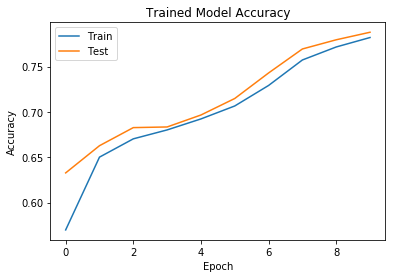

Make a prediction of translation using the model from French to English:
les états unis est généralement pluvieux en juillet et il est généralement agréable en novembre <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [14]:
# build and train a basic RNN on x and y
def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):

    # build the layers and set up parameters to prepare the model to be trained
    learning_rate = 1e-3
    
    input_seq = Input(input_shape[1:])
    rnn = GRU(256, return_sequences=True)(input_seq)
    logits = TimeDistributed(Dense(french_vocab_size, activation='softmax'))(rnn)
    
    model = Model(inputs=input_seq, outputs=logits)
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

# plot the history for accuracy for the training process
def pltrain(history):
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Trained Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# setup the model
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

# print a summary of the model
simple_rnn_model.summary()
print('\n')

# show the graph of the model
plot_model(simple_rnn_model, to_file='model1.png', show_shapes=True)

# model training
history=simple_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=256, epochs=10, validation_split=0.2)

# plot the history for accuracy for the training process
pltrain(history)

# Print a prediction
print("Make a prediction of translation using the model from French to English:")
print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

### Model 2: RNN with Embedding

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 21)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 21, 256)           50944     
_________________________________________________________________
gru_3 (GRU)                  (None, 21, 256)           393984    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 21, 344)           88408     
Total params: 533,336
Trainable params: 533,336
Non-trainable params: 0
_________________________________________________________________


Train on 110288 samples, validate on 27572 samples
Epoch 1/10
110288/110288 [==============================] - 22s 201us/step - loss: 1.5712 - acc: 0.6630 - val_loss: nan - val_acc: 0.8247
Epoch 2/10
110288/110288 [==============================] - 

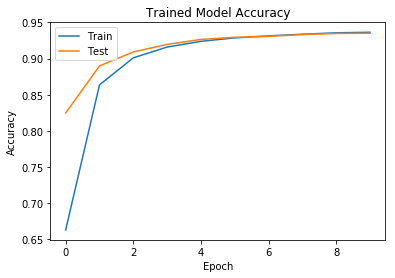

Make a prediction of translation using the model from French to English:
les états unis est généralement froid en juillet et il est généralement en l' <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [18]:
# build and train a RNN model using word embedding on x and y
def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    # Build the layers and set up parameters to prepare the model to be trained
    learning_rate = 1e-3
    
    input_seq = Input(input_shape[1:])
    embed_layer = Embedding(english_vocab_size, 256, input_length=output_sequence_length)(input_seq)
    rnn = GRU(256, return_sequences=True)(embed_layer)

    logits = TimeDistributed(Dense(french_vocab_size, activation='softmax'))(rnn)

    model = Model(inputs=input_seq, outputs=logits)
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate), metrics=['accuracy'])
    return model


# reshape the input
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)

# setup the model
embed_rnn_model = embed_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

# print a summary of the model
embed_rnn_model.summary()
print('\n')

# show the graph of the model
plot_model(embed_rnn_model, to_file='model2.png', show_shapes=True)

# model training
history = embed_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=256, epochs=10, validation_split=0.2)

# plot the history for accuracy for the training process
pltrain(history)

# Print a prediction
print("Make a prediction of translation using the model from French to English:")
print(logits_to_text(embed_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

### Model 3: Bidirectional RNN with Embedding

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 21)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 21, 256)           50944     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 21, 512)           787968    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 21, 344)           176472    
Total params: 1,015,384
Trainable params: 1,015,384
Non-trainable params: 0
_________________________________________________________________


Train on 110288 samples, validate on 27572 samples
Epoch 1/10
110288/110288 [==============================] - 40s 364us/step - loss: 1.3013 - acc: 0.7083 - val_loss: nan - val_acc: 0.8547
Epoch 2/10
110288/110288 [==============================

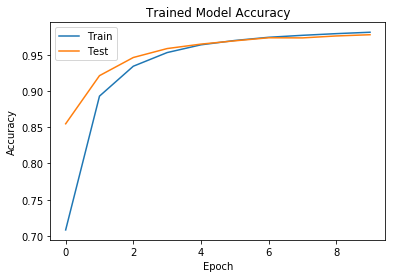

Make a prediction of translation using the model from French to English:
les états unis est généralement froid en juillet et il gèle habituellement en novembre <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [20]:
# build a model that incorporates embedding, and bidirectional RNN on x and y
def Bd_Emb_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    
    # build the layers and set up parameters to prepare the model to be trained
    learning_rate=1e-3

    input_seq = Input(input_shape[1:])
    emb = Embedding(english_vocab_size, 256, input_length=output_sequence_length)(input_seq)
    bdrnn = Bidirectional(GRU(256, return_sequences=True))(emb)
    logits = TimeDistributed(Dense(french_vocab_size, activation='softmax'))(bdrnn)

    model = Model(inputs=input_seq, outputs=logits)
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model

# pad the input
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)

# setup the model
emb_bdrnn = Bd_Emb_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

# print a summary of the model
emb_bdrnn.summary()
print('\n')

# show the graph of the model
plot_model(emb_bdrnn, to_file='model4.png', show_shapes=True)

# model training
history = emb_bdrnn.fit(tmp_x, preproc_french_sentences, batch_size=256, epochs=10, validation_split=0.2)

# plot the history for accuracy for the training process
pltrain(history)

# print a prediction
print("Make a prediction of translation using the model from French to English:")
print(logits_to_text(emb_bdrnn.predict(tmp_x[:1])[0], french_tokenizer))

# 5. Finalizing Trained Model, Saving and Prediction

Comparing all the above trained models, it is obvious that the model of Bidirectional RNN with Embedding performs the best with about 98% accuracy rate after 10 epochs of trainings. So this model is chosen to be the final model for this task of machine translation from English to French.

## Training the final model again with 30 epochs and save it

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 21)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 21, 256)           50944     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 21, 512)           787968    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 21, 344)           176472    
Total params: 1,015,384
Trainable params: 1,015,384
Non-trainable params: 0
_________________________________________________________________


Train on 110288 samples, validate on 27572 samples
Epoch 1/30
110288/110288 [==============================] - 40s 367us/step - loss: 1.3060 - acc: 0.7063 - val_loss: nan - val_acc: 0.8510
Epoch 2/30
110288/110288 [==============================

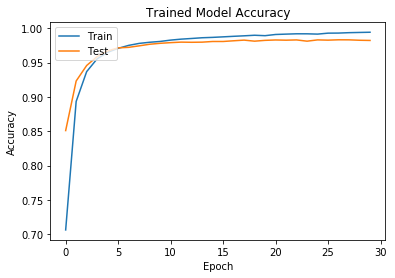

In [21]:
# prepare for training

x = preproc_english_sentences
y = preproc_french_sentences
x_tk = english_tokenizer
y_tk = french_tokenizer

max_english_sequence_length = x.shape[1]
max_french_sequence_length = y.shape[1]
english_vocab_size = len(x_tk.word_index)
french_vocab_size = len(y_tk.word_index)

x = pad(x, max_french_sequence_length)

# set up the model
model = Bd_Emb_model(
        x.shape,
        max_french_sequence_length,
        english_vocab_size,
        french_vocab_size)

# print a summary of the model
model.summary()
print('\n')

# model training
history = model.fit(x, y, batch_size=256, epochs=30, validation_split=0.2)

# plot the history for accuracy for the training process
pltrain(history)

# save the model into "my_final_model.h5"
model.save('my_final_model.h5')

In [22]:
# make translation from English to French with text input using an input model
def translate(model):
    input_txt=input('Please enter some English in lower case:')
    
    y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
    y_id_to_word[0] = '<PAD>'

    sentence = input_txt
    sentence = [x_tk.word_index[word] for word in sentence.split()]
    sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
    sentences = np.array([sentence[0], x[0]])
    predictions = model.predict(sentences, len(sentences))

    print('You have enter:', input_txt)
    print('Translated to French:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))

# load the saved model
model = load_model('my_final_model.h5')

In [38]:
# make translation from English to French with text input using an input model
translate(model)

Please enter some English in lower case:i want to go
You have enter: i want to go
Translated to French:
je veut aller en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [41]:
# make translation from English to French with text input using an input model
translate(model)

Please enter some English in lower case:he is going to france
You have enter: he is going to france
Translated to French:
il va en france <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [54]:
# make translation from English to French with text input using an input model
translate(model)

Please enter some English in lower case:he was driving the yellow car
You have enter: he was driving the yellow car
Translated to French:
il conduisait la voiture voiture <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [52]:
# make translation from English to French with text input using an input model
translate(model)

Please enter some English in lower case:california is sometimes chilly during winter
You have enter: california is sometimes chilly during winter
Translated to French:
californie est parfois froid en l' hiver <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


# 6. Conclusion

Overall, Bidirectional RNN with Embedding model does a good job in machine translation, with high accuracy rate. To further improve the translation quality and range, a bigger training dataset with more unique vocabulary and sentences is required, as well as more complicated pre-processing methods on the data and model architectures. It will also means that a well-equipped computing unit is necessary so that the training can be performed smoothly.